In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch, MeanShift
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

In [72]:
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  'harrywang/wine-dataset-for-clustering',
  'wine-clustering.csv',
)

Using Colab cache for faster access to the 'wine-dataset-for-clustering' dataset.


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


In [74]:
X = df.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

In [75]:
def compute_metrics(X, labels):
    if len(np.unique(labels)) < 2:
        return {'silhouette': np.nan, 'calinski_harabasz': np.nan, 'davies_bouldin': np.nan}
    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_required = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    return {'silhouette': sil, 'calinski_harabasz': ch, 'davies_bouldin': db}

In [76]:
results = {}
labels_dict = {}

# KMeans

In [77]:
range_n_clusters = range(2, 11)
best_n, best_score = 2, -1
for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    preds = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, preds)
    if score > best_score:
        best_score = score
        best_n = n
kmeans = KMeans(n_clusters=best_n, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)
labels_dict['KMeans'] = labels_kmeans
results['KMeans'] = compute_metrics(X_scaled, labels_kmeans)

# Agglomerative Clustering

In [78]:
best_n, best_score = 2, -1
for n in range_n_clusters:
    agg = AgglomerativeClustering(n_clusters=n)
    preds = agg.fit_predict(X_scaled)
    if len(np.unique(preds)) < 2:
        continue
    score = silhouette_score(X_scaled, preds)
    if score > best_score:
        best_score = score
        best_n = n
agg = AgglomerativeClustering(n_clusters=best_n)
labels_agg = agg.fit_predict(X_scaled)
labels_dict['Agglomerative'] = labels_agg
results['Agglomerative'] = compute_metrics(X_scaled, labels_agg)

# DBSCAN

In [91]:
n_features = X_scaled.shape[1]
min_samples = max(2 * n_features, 5)

nbrs = NearestNeighbors(n_neighbors=min_samples, n_jobs=-1).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)
k_distances = distances[:, -1]

k_distances_sorted = np.sort(k_distances)[::-1]

eps = np.percentile(k_distances_sorted, 75)

dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
labels_dbscan = dbscan.fit_predict(X_scaled)

n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)

if n_clusters <= 1:
    eps = np.percentile(k_distances_sorted, 60)
    min_samples = max(min_samples, 10)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels_dbscan = dbscan.fit_predict(X_scaled)

# Birch

In [80]:
best_n_birch, best_score_birch = 2, -1
best_labels_birch = None

for n in range(2, 10):
    birch = Birch(n_clusters=n)
    preds = birch.fit_predict(X_scaled)
    if len(np.unique(preds)) < 2:
        continue
    try:
        score = silhouette_score(X_scaled, preds)
        if score > best_score_birch:
            best_score_birch = score
            best_n_birch = n
            best_labels_birch = preds
    except:
        continue

labels_dict['Birch'] = best_labels_birch
results['Birch'] = compute_metrics(X_scaled, best_labels_birch)

# MeanShift

In [81]:
mean_shift = MeanShift()
labels_ms = mean_shift.fit_predict(X_scaled)
labels_dict['MeanShift'] = labels_ms
results['MeanShift'] = compute_metrics(X_scaled, labels_ms)

# Сравнение метрик

In [92]:
metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df.round(3)
print(metrics_df)


               silhouette  calinski_harabasz  davies_bouldin
KMeans              0.285             70.940           1.389
Agglomerative       0.277             67.647           1.419
DBSCAN              0.234              4.854           2.937
Birch               0.277             67.647           1.419
MeanShift           0.224              6.435           1.320


* KMeans продемонстрировал наилучшие результаты: максимальные значения Silhouette Score (0.285) и Calinski–Harabasz Index (70.94), что указывает на компактность кластеров и чёткое их разделение.
* Birch и Agglomerative Clustering показали практически идентичные метрики, подтверждая устойчивость иерархических подходов на этих данных.
* DBSCAN показал худшие результаты: крайне низкий Calinski–Harabasz (4.85) и высокий Davies–Bouldin (2.94), что говорит о слабой компактности и плохой разделимости кластеров — вероятно, из-за несоответствия структуры данных предположениям алгоритма или неудачного выбора eps.
* MeanShift продемонстрировал умеренный silhouette, но при этом очень низкий Calinski–Harabasz (6.44), что также указывает на неэффективное разделение пространства признаков.

# Визуализация

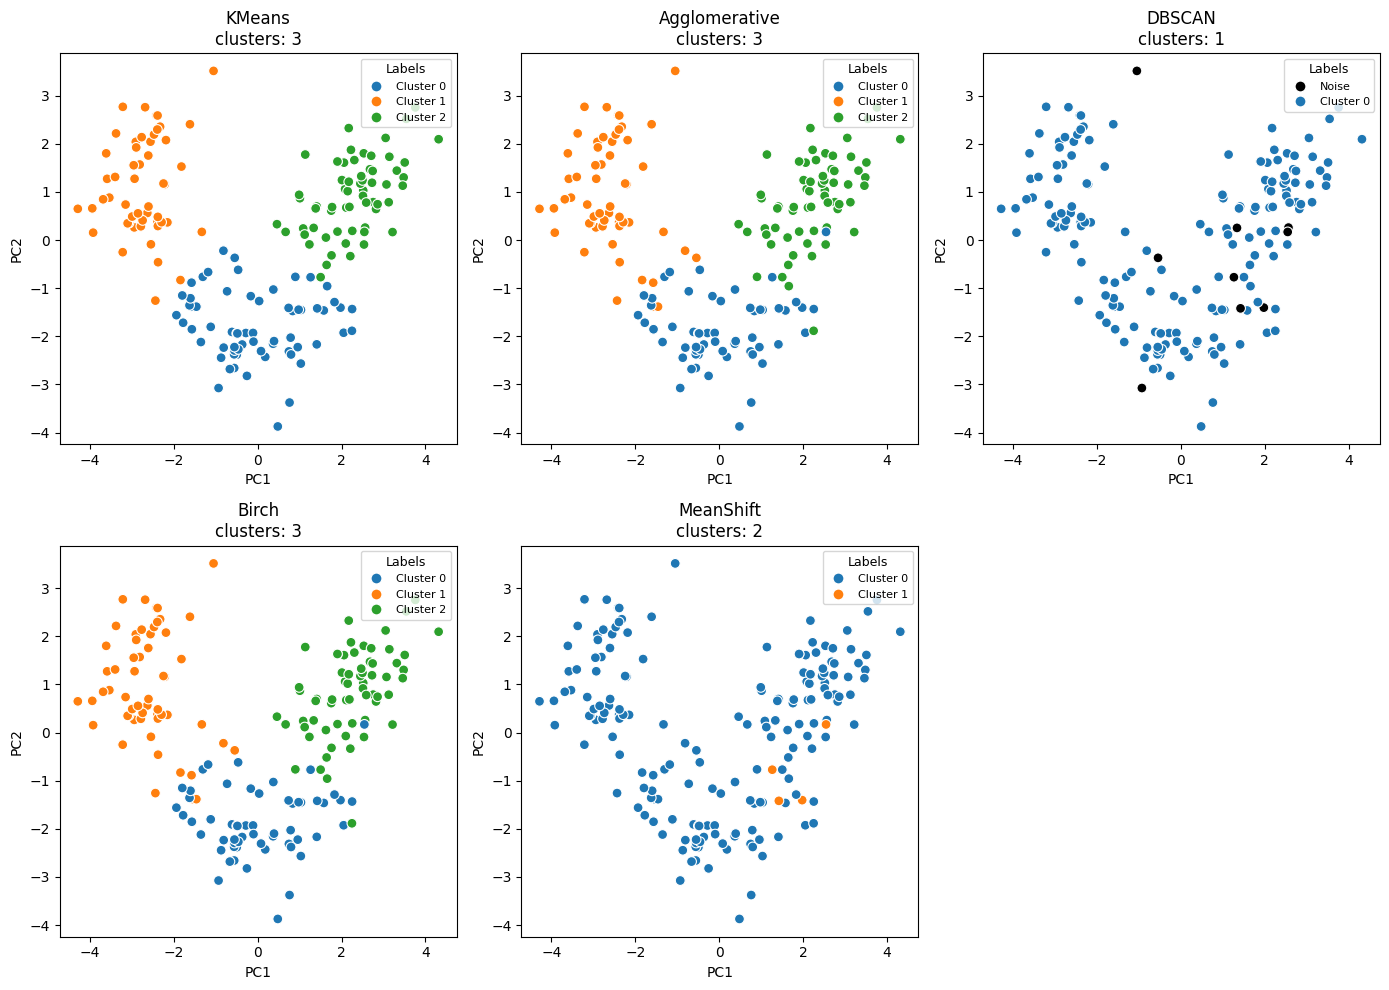

In [93]:
fixed_colors = list(plt.cm.tab10.colors)

fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.ravel()
methods = list(labels_dict.keys())

for i, method in enumerate(methods):
    ax = axes[i]
    labels = labels_dict[method]
    unique_labels = np.unique(labels)

    color_map = {}
    cluster_idx = 0
    for label in unique_labels:
        if label == -1:
            color_map[-1] = 'black'
        else:
            color_map[label] = fixed_colors[cluster_idx % len(fixed_colors)]
            cluster_idx += 1

    point_colors = [color_map[label] for label in labels]
    scatter = ax.scatter(
        X_2d[:, 0],
        X_2d[:, 1],
        c=point_colors,
        s=50,
        edgecolors='white',
        linewidth=0.8,
    )

    legend_elements = [
        plt.Line2D(
            [0], [0],
            marker='o',
            color='w',
            markerfacecolor=color_map[label],
            markersize=8,
            label='Noise' if label == -1 else f'Cluster {label}'
        )
        for label in unique_labels
    ]

    ax.legend(
        handles=legend_elements,
        loc='upper right',
        fontsize=8,
        frameon=True,
        fancybox=True,
        shadow=False,
        title='Labels',
        title_fontsize=9,
    )

    n_clusters = int(len(unique_labels) - (1 if -1 in unique_labels else 0))
    ax.set_title(f'{method}\nclusters: {n_clusters}', fontsize=12)
    ax.set_xlabel('PC1', fontsize=10)
    ax.set_ylabel('PC2', fontsize=10)

axes[-1].axis('off')

plt.tight_layout()
plt.show()

* KMeans, Agglomerative Clustering и Birch выделили три чётко разделённых кластера, что согласуется с их высокими значениями метрик (особенно Silhouette и Calinski–Harabasz). Визуально кластеры компактны и хорошо отделены друг от друга — это подтверждает стабильность и эффективность этих методов на данных.
* DBSCAN нашёл всего один основной кластер и множество шумовых точек (чёрные точки), что объясняет его низкие оценки. Алгоритм не смог адаптироваться к структуре данных — возможно, из-за неоднородной плотности или неоптимальных параметров (eps, min_samples).
* MeanShift также выделил два кластера, но они менее компактны и размыты по границам — это согласуется с его низким Calinski–Harabasz (6.44) и средним силуэтом (0.224). Метод не обеспечил чёткого разделения, что снижает его применимость в данном случае.